In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

In [2]:
def thresholding(image):
    img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_grey,180,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh,cmap='gray')
    return thresh


In [3]:

def resize_image(image, width, height):
    """Resize the image to the specified width and height."""
    return cv2.resize(image, (width, height))



In [4]:

def find_image_size(image):
    """Find the size (height, width) of the image."""
    height, width = image.shape[:2]
    return height, width


In [5]:

def calculate_horizontal_projection(image):
    """Calculate the horizontal projection (row sum of pixels) for the image."""
    projection = np.sum(image, axis=1)
    return projection

In [6]:
def divide_image_vertical(image, num_chunks):
    """
    Divide the image into equal number of vertical chunks.

    Parameters:
    - image: Input image (numpy array).
    - num_chunks: Number of vertical chunks to divide the image into.

    Returns:
    - chunked_images: List of images, each representing a vertical chunk of the input image.
    """
    height, width = image.shape
    chunk_width = width // num_chunks
    chunked_images = []
    for i in range(num_chunks):
        start_x = i * chunk_width
        end_x = start_x + chunk_width
        chunk = image[:, start_x:end_x]
        chunked_images.append(chunk)
    return chunked_images


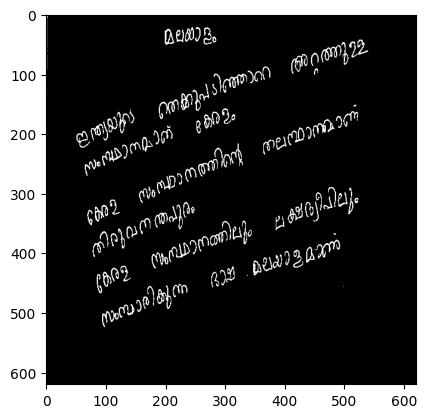

In [7]:
# Load the image
img = cv2.imread('mal1.jpg')  # Load as grayscale

image = resize_image(img, 620, 620) 

thresh_img = thresholding(image)


# Step 1: Find the size of the image
height, width = find_image_size(thresh_img)

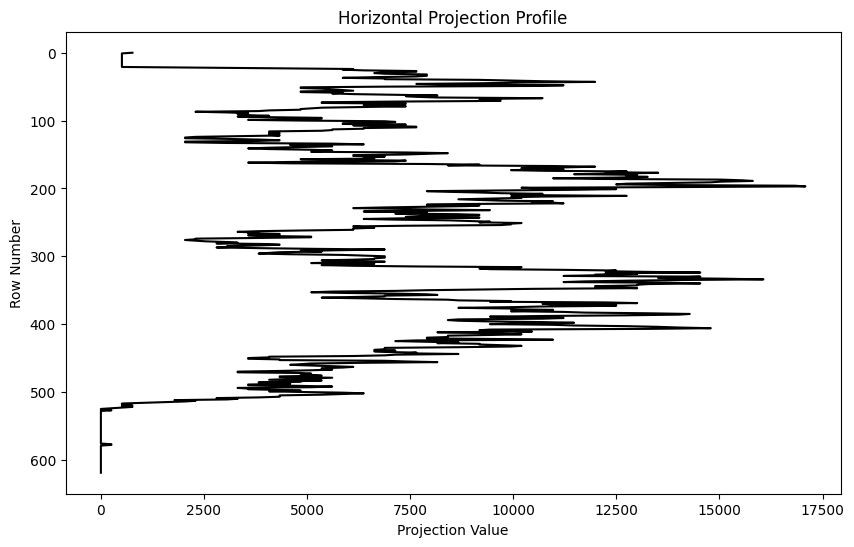

In [8]:
horizontal_projection = np.sum(thresh_img, axis=1)

# Create y-axis values (row numbers)
y_values = np.arange(thresh_img.shape[0])

# Plot the horizontal projection
plt.figure(figsize=(10, 6))
plt.plot(horizontal_projection, y_values, color='black')
plt.title('Horizontal Projection Profile')
plt.xlabel('Projection Value')
plt.ylabel('Row Number')
plt.gca().invert_yaxis()  # Invert y-axis to have row 0 at the top
plt.show()

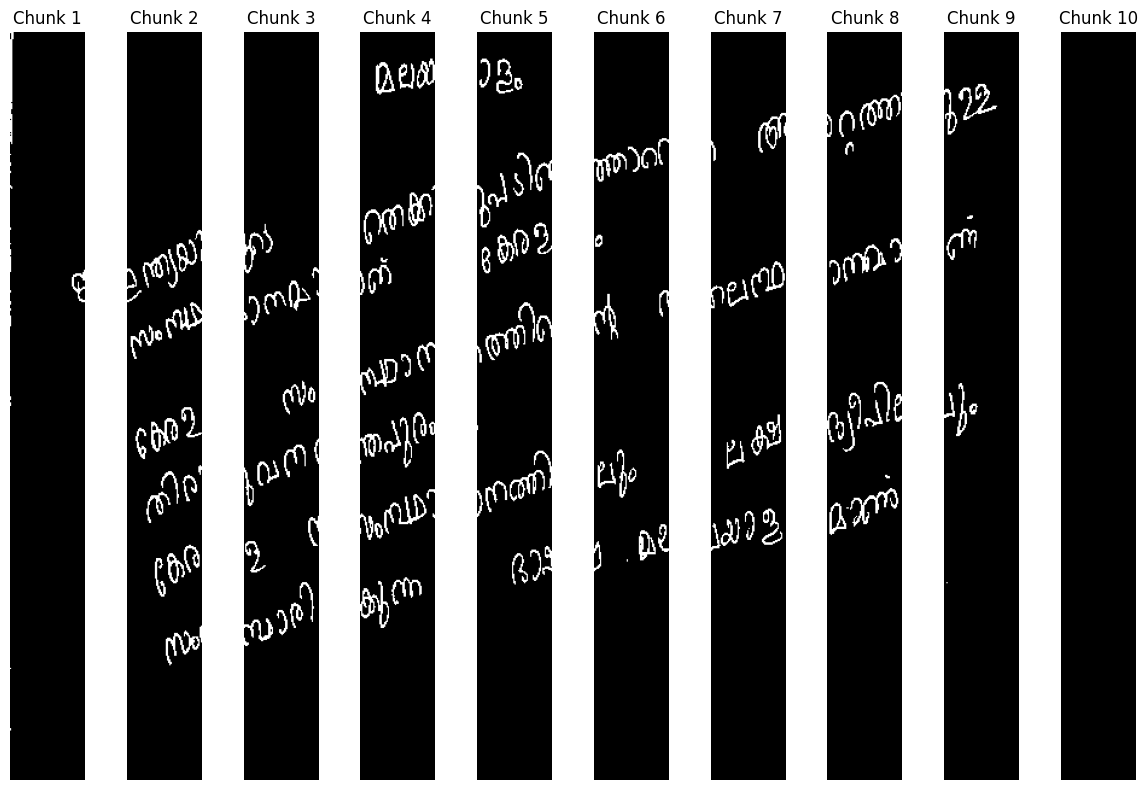

In [9]:
# Divide the image into  vertical chunks
num_chunks = 10
chunked_images = divide_image_vertical(thresh_img, num_chunks)

# Display the segmented chunks
plt.figure(figsize=(12, 8))
for i, chunk in enumerate(chunked_images):
    plt.subplot(1, num_chunks, i + 1)
    plt.imshow(chunk, cmap='gray')
    plt.title(f'Chunk {i+1}')
    plt.axis('off')  # Hide axis labels and ticks

plt.tight_layout()
plt.show()



In [10]:
def divide_image_vertical_25(image):

    height,width = image.shape
    chunk_width_25 = width // 4  # 25% of the image width
    chunk_width_75 = width - chunk_width_25  # 75% of the image width
    
    start_x = 0
    end_x = start_x + chunk_width_25
    chunk = image[:, start_x:end_x]
    
    return chunk


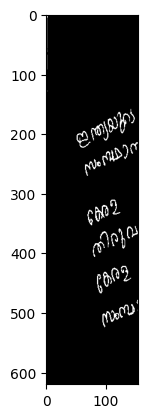

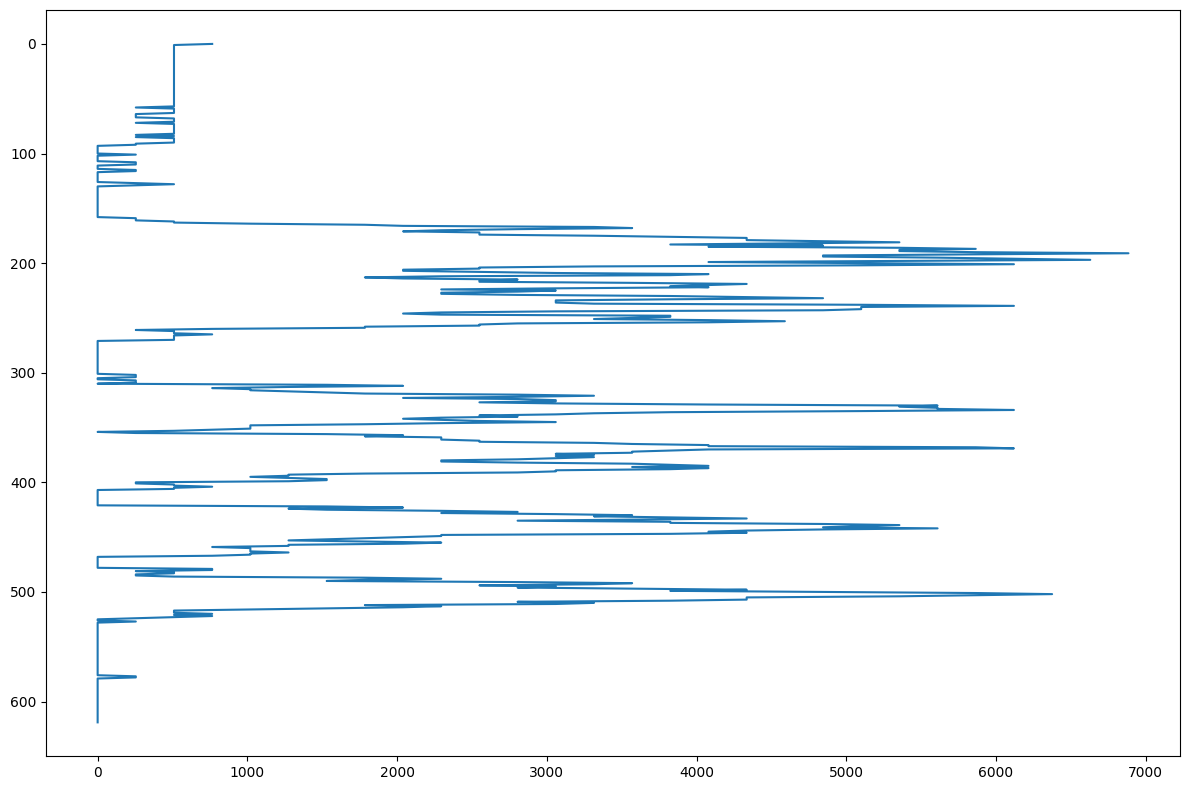

In [11]:
chunk_25 = divide_image_vertical_25(thresh_img)
plt.imshow(chunk_25,cmap='gray')

# Plot the horizontal projection profile for each chunk separately
plt.figure(figsize=(12, 8))

horizontal_projection_25 = calculate_horizontal_projection(chunk_25)
y_values_25 = np.arange(len(horizontal_projection_25))  # Generate y-values based on the length of horizontal_projection
plt.plot(horizontal_projection_25, y_values_25)
plt.gca().invert_yaxis()  # Invert y-axis to have row 0 at the top

plt.tight_layout()
plt.show()


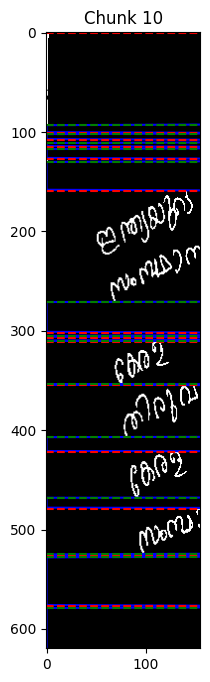

In [12]:
# Plot each chunk with its corresponding horizontal projection profile and detected start/end points
plt.figure(figsize=(12, 8))
in_start_points = []  # Initialize start points list
in_end_points = []  # Initialize end points list


# Calculate horizontal projection
horizontal_projection_25 = calculate_horizontal_projection(chunk_25)
y_values = np.arange(len(horizontal_projection_25))  # Row numbers

# Plot the horizontal projection profile
plt.plot(horizontal_projection_25, y_values, color='blue', label='Projection Profile')
plt.imshow(chunk_25, cmap='gray')

# Find starting and ending points for line segmentation
start_chunk = []  # Initialize start points for the current chunk
end_chunk = []  # Initialize end points for the current chunk
start_found = False
for j in range(len(horizontal_projection_25)):
    if horizontal_projection_25[j] == 0 and not start_found:
        continue
    elif horizontal_projection_25[j] > 0 and not start_found:
        start_chunk.append(j)  # Append start point to the current chunk's start points list
        start_found = True
    elif horizontal_projection_25[j] == 0 and start_found:
        end_chunk.append(j)  # Append end point to the current chunk's end points list
        start_found = False

in_start_points = start_chunk 
in_end_points = end_chunk

# Draw detected start and end points
for start_point in start_chunk:
    plt.axhline(y=start_point, color='red', linestyle='--', label='Start Point')
for end_point in end_chunk:
    plt.axhline(y=end_point, color='green', linestyle='--', label='End Point')

# Set plot properties
plt.title(f'Chunk {i+1}')

plt.show()


In [13]:
def find_connected_components(image):
    # Convert the image to binary
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    return num_labels, labels, stats

def find_average_height(stats):
    heights = stats[:, 3]  # Get the heights of all connected components
    return np.mean(heights)


In [14]:
#  step 1: find connected components
num_labels, labels, stats = find_connected_components(thresh_img)
    
# Step 2: Find average height
average_height = find_average_height(stats)

print(average_height)
print(average_height/4)

21.505494505494507
5.376373626373627


In [15]:
print(in_start_points)
print(in_end_points)

[0, 101, 108, 115, 127, 159, 302, 307, 311, 355, 422, 479, 527, 577]
[93, 102, 111, 117, 130, 271, 305, 310, 354, 407, 468, 525, 528, 579]


In [16]:
i = 0
while(i < len(in_start_points)):
    if abs(in_end_points[i]  - in_start_points[i] ) < average_height/4 :
        del in_start_points[i]
        del in_end_points[i]
    else:
        i += 1 


In [17]:
print(in_start_points)
print(in_end_points)

[0, 159, 311, 355, 422, 479]
[93, 271, 354, 407, 468, 525]


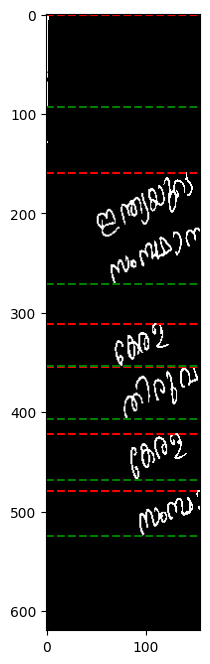

In [18]:
plt.figure(figsize=(12, 8))

plt.imshow(chunk_25, cmap='gray')

# Draw detected start points
for start_point in in_start_points:
    plt.axhline(y=start_point, color='red', linestyle='--', label='Start Point')

# Draw detected end points
for end_point in in_end_points:
    plt.axhline(y=end_point, color='green', linestyle='--', label='End Point')

plt.show()


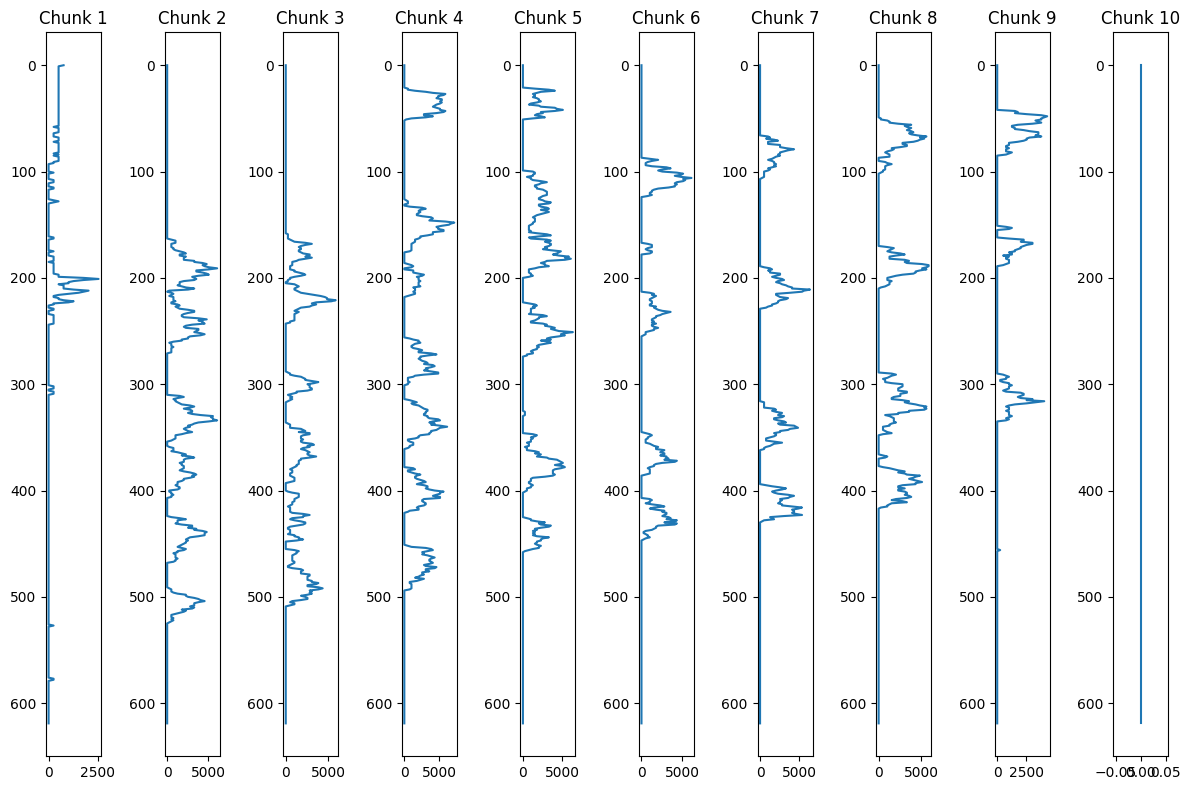

In [19]:
# Plot the horizontal projection profile for each chunk separately
plt.figure(figsize=(12, 8))
for i, chunk in enumerate(chunked_images):
    plt.subplot(1, num_chunks, i + 1)
    horizontal_projection = calculate_horizontal_projection(chunk)
    y_values = np.arange(len(horizontal_projection))  # Generate y-values based on the length of horizontal_projection
    plt.plot(horizontal_projection, y_values)
    plt.title(f'Chunk {i+1}')
    plt.gca().invert_yaxis()  # Invert y-axis to have row 0 at the top

plt.tight_layout()
plt.show()


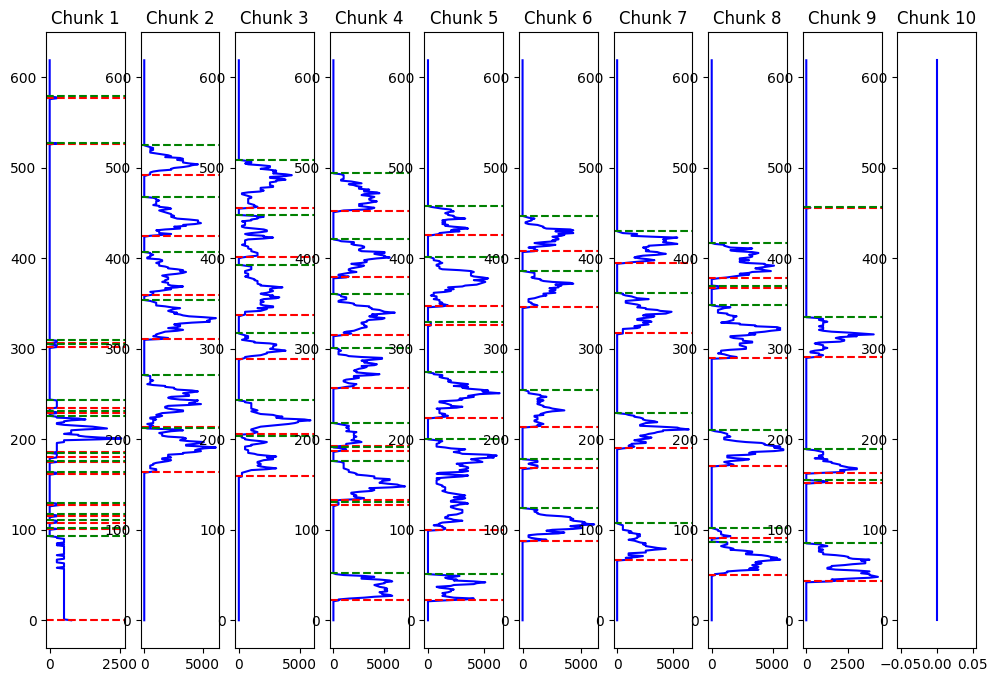

In [20]:
# Plot each chunk with its corresponding horizontal projection profile and detected start/end points
plt.figure(figsize=(12, 8))
start_points = []  # Initialize start points list
end_points = []  # Initialize end points list

for i, chunk in enumerate(chunked_images):
    plt.subplot(1, num_chunks, i + 1)
    
    # Calculate horizontal projection
    horizontal_projection = calculate_horizontal_projection(chunk)
    y_values = np.arange(len(horizontal_projection))  # Row numbers
    
    # Plot the horizontal projection profile
    plt.plot(horizontal_projection, y_values, color='blue', label='Projection Profile')
    
    # Find starting and ending points for line segmentation
    start_chunk = []  # Initialize start points for the current chunk
    end_chunk = []  # Initialize end points for the current chunk
    start_found = False
    for j in range(len(horizontal_projection)):
        if horizontal_projection[j] == 0 and not start_found:
            continue
        elif horizontal_projection[j] > 0 and not start_found:
            start_chunk.append(j)  # Append start point to the current chunk's start points list
            start_found = True
        elif horizontal_projection[j] == 0 and start_found:
            end_chunk.append(j)  # Append end point to the current chunk's end points list
            start_found = False
    
    start_points.append(start_chunk)  # Append the current chunk's start points to the overall start points list
    end_points.append(end_chunk)  # Append the current chunk's end points to the overall end points list

    # Draw detected start and end points
    for start_point in start_chunk:
        plt.axhline(y=start_point, color='red', linestyle='--', label='Start Point')
    for end_point in end_chunk:
        plt.axhline(y=end_point, color='green', linestyle='--', label='End Point')
    
    # Set plot properties
    plt.title(f'Chunk {i+1}')

plt.show()


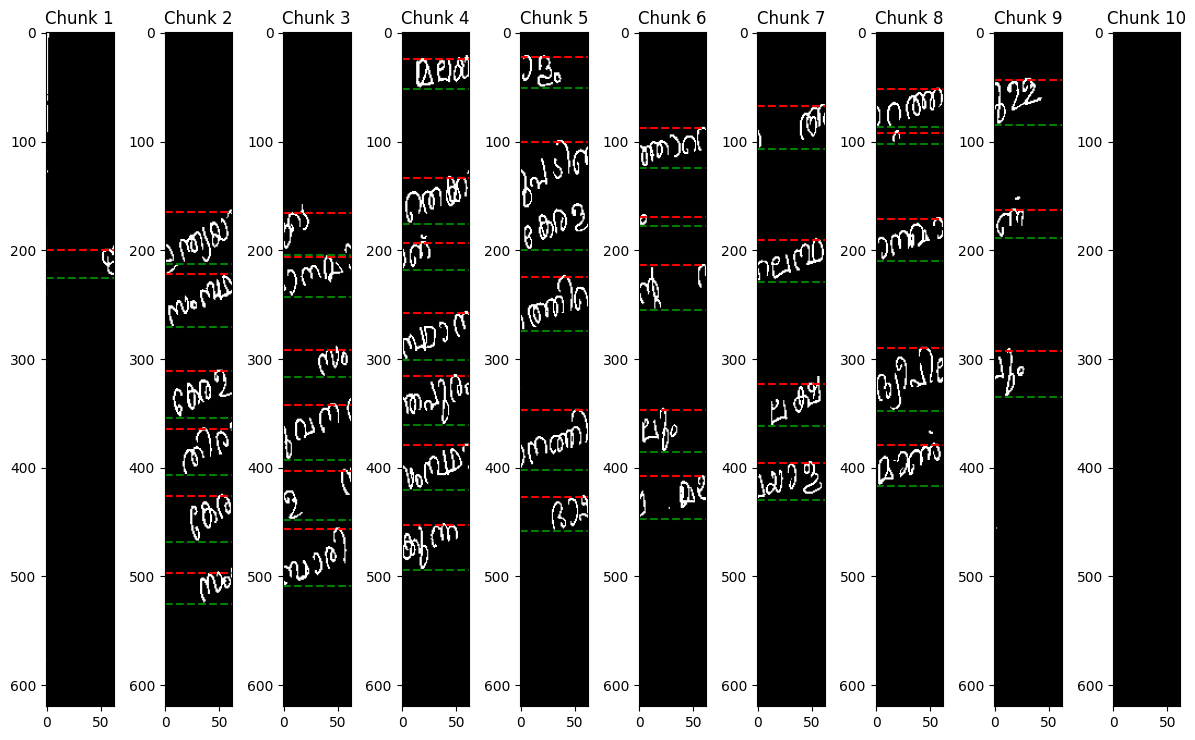

In [21]:

# Plot each chunk with its corresponding horizontal projection profile and detected start/end points
plt.figure(figsize=(12, 8))
start_points = []  # Initialize start points list
end_points = []  # Initialize end points list

# start_points.append(in_start_points)
# end_points.append(in_end_points)

for i, chunk in enumerate(chunked_images):
    plt.subplot(1, num_chunks, i + 1)
    
    # Calculate horizontal projection
    horizontal_projection = calculate_horizontal_projection(chunk)
    y_values = np.arange(len(horizontal_projection))  # Row numbers
    
    # Plot the horizontal projection profile
    plt.imshow(chunk, cmap='gray')
    
    # Find starting and ending points for line segmentation
    start_chunk = []  # Initialize start points for the current chunk
    end_chunk = []  # Initialize end points for the current chunk
    start_found = False
    for j in range(len(horizontal_projection)):
        if horizontal_projection[j] == 0 and not start_found:
            continue
        elif horizontal_projection[j] > 1000 and not start_found:
            start_chunk.append(j)  # Append start point to the current chunk's start points list
            start_found = True
        elif horizontal_projection[j] == 0 and start_found:
            end_chunk.append(j)  # Append end point to the current chunk's end points list
            start_found = False

    # Remove lines where the distance between start and end points is less than min_distance
    min_distance = 5
    
    k = 0
    while k < len(start_chunk) :
        if abs(end_chunk[k] - start_chunk[k]) < min_distance:
            del start_chunk[k]
            del end_chunk[k]
        else:
            k += 1

    # k = 0
    # while k < len(start_chunk) :
    #     if abs(end_chunk[k] - start_chunk[k]) < min_distance:
    #         del start_chunk[k]
    #         del end_chunk[k]
    #     else:
    #         k += 1
            

    start_points.append(start_chunk)  # Append the current chunk's start points to the overall start points list
    end_points.append(end_chunk)  # Append the current chunk's end points to the overall end points list

    # Draw detected start and end points
    for start_point in start_chunk:
        plt.axhline(y=start_point, color='red', linestyle='--', label='Start Point')
    for end_point in end_chunk:
        plt.axhline(y=end_point, color='green', linestyle='--', label='End Point')
    
    # Set plot properties
    plt.title(f'Chunk {i+1}')
    plt.tight_layout()

plt.show()


In [22]:
print(start_points)
print('\n')
print(end_points)

[[200], [165, 222, 311, 364, 426, 497], [166, 206, 292, 342, 403, 456], [24, 134, 193, 258, 316, 379, 453], [22, 100, 225, 347, 427], [88, 169, 214, 347, 408], [67, 191, 323, 396], [52, 92, 171, 290, 379], [43, 163, 293], []]


[[226], [213, 271, 354, 407, 468, 525], [204, 243, 317, 393, 448, 509], [52, 176, 218, 301, 361, 421, 494], [51, 200, 274, 402, 458], [124, 178, 255, 386, 447], [107, 229, 362, 430], [87, 102, 210, 348, 417], [85, 189, 335], []]


In [23]:
start_points[0] = in_start_points
end_points[0] = in_end_points

In [24]:
print(start_points)
print('\n')
print(end_points)

[[0, 159, 311, 355, 422, 479], [165, 222, 311, 364, 426, 497], [166, 206, 292, 342, 403, 456], [24, 134, 193, 258, 316, 379, 453], [22, 100, 225, 347, 427], [88, 169, 214, 347, 408], [67, 191, 323, 396], [52, 92, 171, 290, 379], [43, 163, 293], []]


[[93, 271, 354, 407, 468, 525], [213, 271, 354, 407, 468, 525], [204, 243, 317, 393, 448, 509], [52, 176, 218, 301, 361, 421, 494], [51, 200, 274, 402, 458], [124, 178, 255, 386, 447], [107, 229, 362, 430], [87, 102, 210, 348, 417], [85, 189, 335], []]


In [25]:
i = 0
while(i < len(start_points)):
    j = 0
    while(j < len(start_points[i])):
        if abs(end_points[i][j-1]  - start_points[i][j] ) < average_height/4 :
            del start_points[i][j]
            del end_points[i][j-1]
        else:
            j += 1
    i += 1 


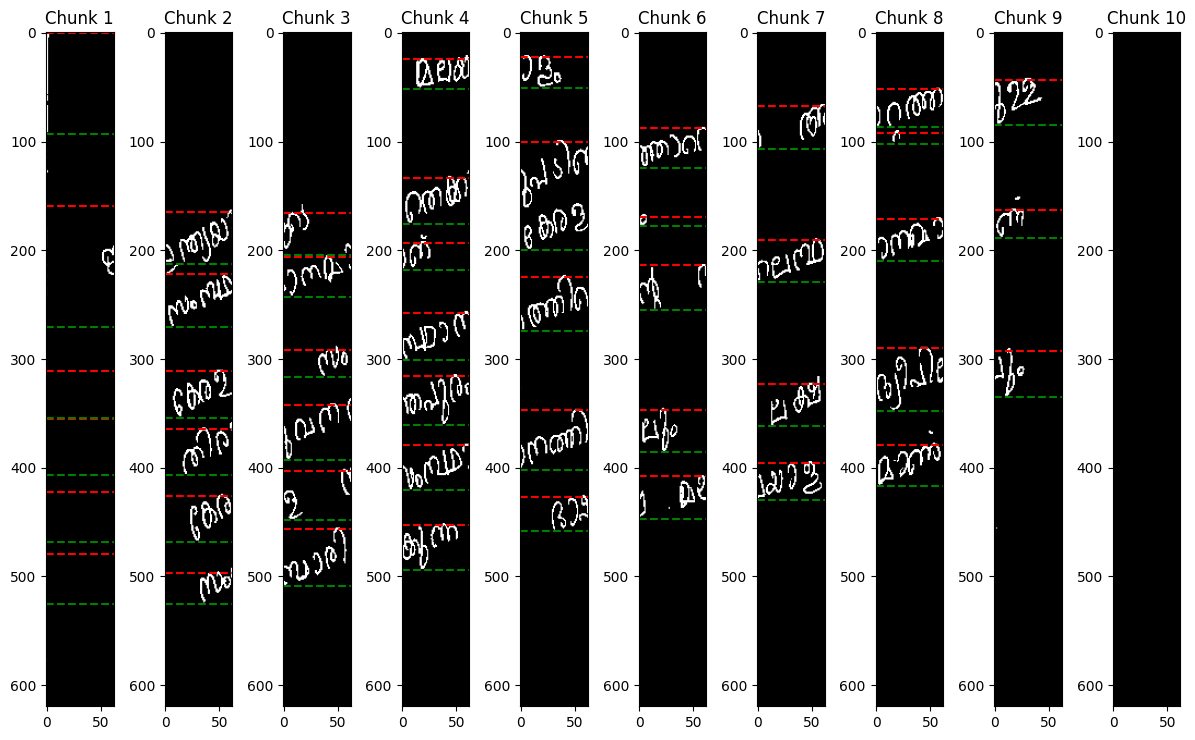

In [25]:

# Plot each chunk with its corresponding horizontal projection profile and detected start/end points
plt.figure(figsize=(12, 8))
for i, chunk in enumerate(chunked_images):
    plt.subplot(1, num_chunks, i + 1)
    
    # Plot the horizontal projection profile
    plt.imshow(chunk, cmap='gray')

    # Draw detected start and end points
    for start_point in start_points[i]:
        plt.axhline(y=start_point, color='red', linestyle='--', label='Start Point')
    for end_point in end_points[i]:
        plt.axhline(y=end_point, color='green', linestyle='--', label='End Point')
    
    # Set plot properties
    plt.title(f'Chunk {i+1}')
    plt.tight_layout()

plt.show()


In [26]:
print(start_points)
print('\n')
print(end_points)

[[0, 159, 311, 355, 422, 479], [165, 222, 311, 364, 426, 497], [166, 206, 292, 342, 403, 456], [24, 134, 193, 258, 316, 379, 453], [22, 100, 225, 347, 427], [88, 169, 214, 347, 408], [67, 191, 323, 396], [52, 92, 171, 290, 379], [43, 163, 293], []]


[[93, 271, 354, 407, 468, 525], [213, 271, 354, 407, 468, 525], [204, 243, 317, 393, 448, 509], [52, 176, 218, 301, 361, 421, 494], [51, 200, 274, 402, 458], [124, 178, 255, 386, 447], [107, 229, 362, 430], [87, 102, 210, 348, 417], [85, 189, 335], []]


In [27]:
i = 0
while i < len(start_points):
    j = 0
    while j < len(start_points[i]):
        if abs(end_points[i][j] - start_points[i][j]) > 3 * average_height:
            # Step 3: Find the rows corresponding to minimum HP value within the line segment
            start_row = start_points[i][j]
            end_row = end_points[i][j]
            min_hp_row = np.argmin(np.sum(chunked_images[i][start_row + 10:end_row, :], axis=1)) + start_row

            

            # Step 4: Segment the line segment into two at the minimum HP value position
            new_end_row = min_hp_row
            new_start_row = new_end_row + 1

            print('chunk idx =', i, 'start =',start_row, 'end = ', end_row,'n_start =', new_start_row, 'n_end = ', new_end_row, 'min_hp_row = ', min_hp_row)
            
            # Update start and end points
            end_points[i].insert(j, new_end_row)
            start_points[i].insert(j+1 , new_start_row)
            
            j += 2  # Move to the next line segment after inserting the new start and end points
        else:
            j += 1
    i += 1



chunk idx = 0 start = 0 end =  93 n_start = 49 n_end =  48 min_hp_row =  48
chunk idx = 0 start = 159 end =  271 n_start = 160 n_end =  159 min_hp_row =  159
chunk idx = 4 start = 100 end =  200 n_start = 142 n_end =  141 min_hp_row =  141


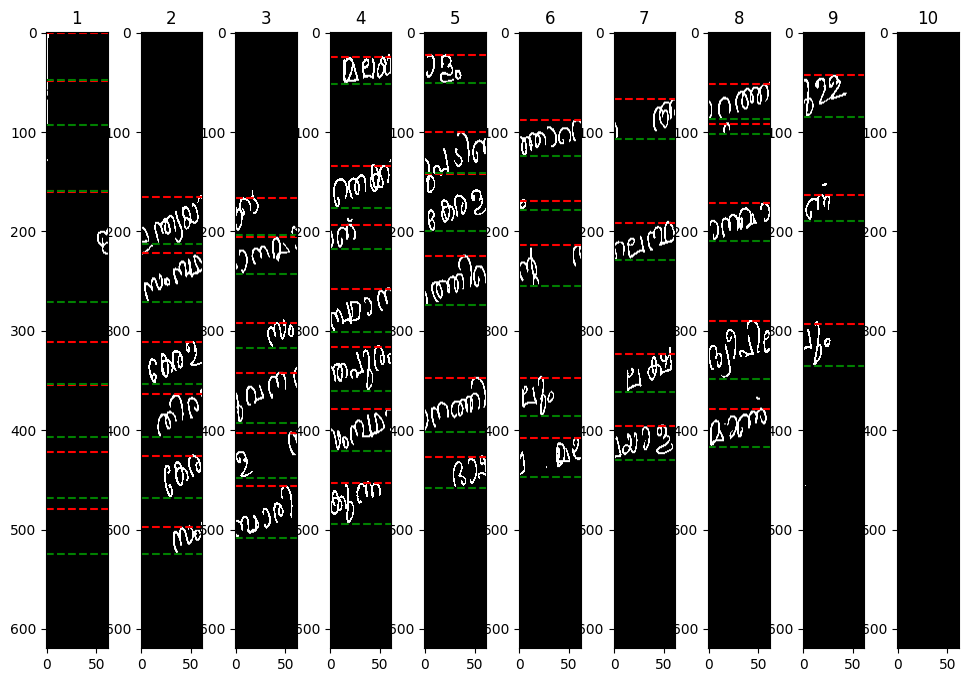

In [28]:

# Plot each chunk with its corresponding horizontal projection profile and detected start/end points
plt.figure(figsize=(12, 8))
for i, chunk in enumerate(chunked_images):
    plt.subplot(1, num_chunks, i + 1)
    
    # Plot the horizontal projection profile
    plt.imshow(chunk, cmap='gray')

    # Draw detected start and end points
    for start_point in start_points[i]:
        plt.axhline(y=start_point, color='red', linestyle='--', label='Start Point')
    for end_point in end_points[i]:
        plt.axhline(y=end_point, color='green', linestyle='--', label='End Point')

    # Hide x and y axis ticks and labels
    # plt.xticks([])
    # plt.yticks([])
    
    # Set plot properties
    plt.title(f'{i+1}')
    # plt.tight_layout()


plt.show()


In [29]:
print(start_points)
print('\n')
print(end_points)

[[0, 49, 159, 160, 311, 355, 422, 479], [165, 222, 311, 364, 426, 497], [166, 206, 292, 342, 403, 456], [24, 134, 193, 258, 316, 379, 453], [22, 100, 142, 225, 347, 427], [88, 169, 214, 347, 408], [67, 191, 323, 396], [52, 92, 171, 290, 379], [43, 163, 293], []]


[[48, 93, 159, 271, 354, 407, 468, 525], [213, 271, 354, 407, 468, 525], [204, 243, 317, 393, 448, 509], [52, 176, 218, 301, 361, 421, 494], [51, 141, 200, 274, 402, 458], [124, 178, 255, 386, 447], [107, 229, 362, 430], [87, 102, 210, 348, 417], [85, 189, 335], []]


In [30]:
def find_nearest_element(list, point, limit):

    min_distance = float('inf')
    nearest_elem = None
    
    for i in range(len(list)):
        
        elem = list[i]
        distance = abs(elem - point)
        
        if distance < min_distance and distance <= limit:
            min_distance = distance
            nearest_elem = list[i]

    return nearest_elem

In [31]:
def find_nearest_min_hp(start_row, end_row, chunk):
    start_row = int(start_row)
    end_row = int(end_row)
    if start_row < end_row:
        horizontal_projection = np.sum(chunk[start_row:end_row, :], axis=1)
        if len(horizontal_projection) > 0:
            min_hp_index = np.argmin(horizontal_projection)
            return start_row + min_hp_index
    return None


In [32]:

# Define a function to compare adjacent chunks and update start points accordingly
def compare_adjacent_chunks(points_list, average_height):
    i = 0
    while i < (len(points_list)-1) :

        for j, point in enumerate(points_list[i]):
            nearest = find_nearest_element(points_list[i+1],points_list[i][j], 2*average_height)
            if nearest == None:
                points_list[i+1].append(points_list[i][j])

        for j, point in enumerate(points_list[i+1]):
            nearest = find_nearest_element(points_list[i],points_list[i+1][j], 2*average_height)
            if nearest == None:
                points_list[i].append(points_list[i+1][j])
        i = i + 1

         


# Usage example
compare_adjacent_chunks(start_points, average_height)
compare_adjacent_chunks(end_points, average_height)


In [33]:
# sort the points

i = 0
while i < len(start_points):
    start_points[i].sort() 
    i += 1

i = 0
while i < len(end_points):
    end_points[i].sort() 
    i += 1

In [34]:
print(start_points)
print('\n')
print(end_points)

[[0, 49, 159, 160, 222, 311, 355, 422, 479], [0, 49, 165, 222, 311, 364, 426, 497], [0, 49, 166, 206, 292, 342, 403, 456], [24, 134, 193, 258, 316, 379, 453], [22, 100, 142, 225, 347, 427], [22, 88, 169, 214, 347, 408], [22, 67, 191, 323, 396], [52, 92, 171, 290, 379], [43, 92, 163, 293, 379], [43, 92, 163, 293, 379]]


[[48, 93, 159, 213, 271, 354, 407, 468, 525], [48, 93, 159, 213, 271, 354, 407, 468, 525], [48, 93, 159, 204, 243, 317, 393, 448, 509], [52, 176, 218, 301, 361, 421, 494], [51, 141, 200, 274, 402, 458], [51, 124, 178, 255, 386, 447], [51, 107, 178, 229, 362, 430], [87, 102, 210, 348, 417], [85, 189, 335, 417], [85, 189, 335, 417]]


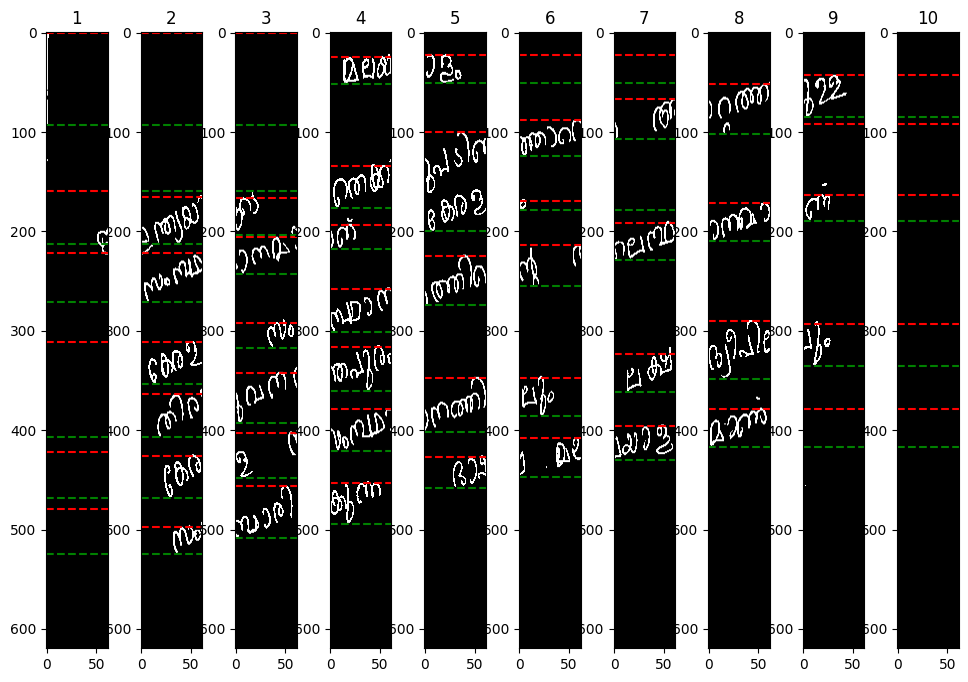

In [39]:
# Plot each chunk with its corresponding horizontal projection profile and detected start/end points
plt.figure(figsize=(12, 8))
for i, chunk in enumerate(chunked_images):
    plt.subplot(1, num_chunks, i + 1)
    
    # Plot the horizontal projection profile
    plt.imshow(chunk, cmap='gray')

    # Draw detected start and end points
    for start_point in start_points[i]:
        plt.axhline(y=start_point, color='red', linestyle='--', label='Start Point')
    for end_point in end_points[i]:
        plt.axhline(y=end_point, color='green', linestyle='--', label='End Point')

    # Hide x and y axis ticks and labels
    # plt.xticks([])
    # plt.yticks([])
    
    # Set plot properties
    plt.title(f'{i+1}')
    # plt.tight_layout()


plt.show()

In [40]:
print(start_points)
print('\n')
print(end_points)

[[0, 159, 222, 311, 422, 479], [0, 165, 222, 311, 364, 426, 497], [0, 166, 206, 292, 342, 403, 456], [24, 134, 193, 258, 316, 379, 453], [22, 100, 225, 347, 427], [22, 88, 169, 214, 347, 408], [22, 67, 191, 323, 396], [52, 171, 290, 379], [43, 92, 163, 293, 379], [43, 92, 163, 293, 379]]


[[93, 213, 271, 407, 468, 525], [93, 159, 213, 271, 354, 407, 468, 525], [93, 159, 204, 243, 317, 393, 448, 509], [52, 176, 218, 301, 361, 421, 494], [51, 200, 274, 402, 458], [51, 124, 178, 255, 386, 447], [51, 107, 178, 229, 362, 430], [102, 210, 348, 417], [85, 189, 335, 417], [85, 189, 335, 417]]


In [41]:
i = 0
while(i < len(start_points)):
    j = 0
    while(j < len(start_points[i])):
        if abs(end_points[i][j-1]  - start_points[i][j] ) < average_height/4 :
            del start_points[i][j]
            del end_points[i][j-1]
        else:
            j += 1
    i += 1 


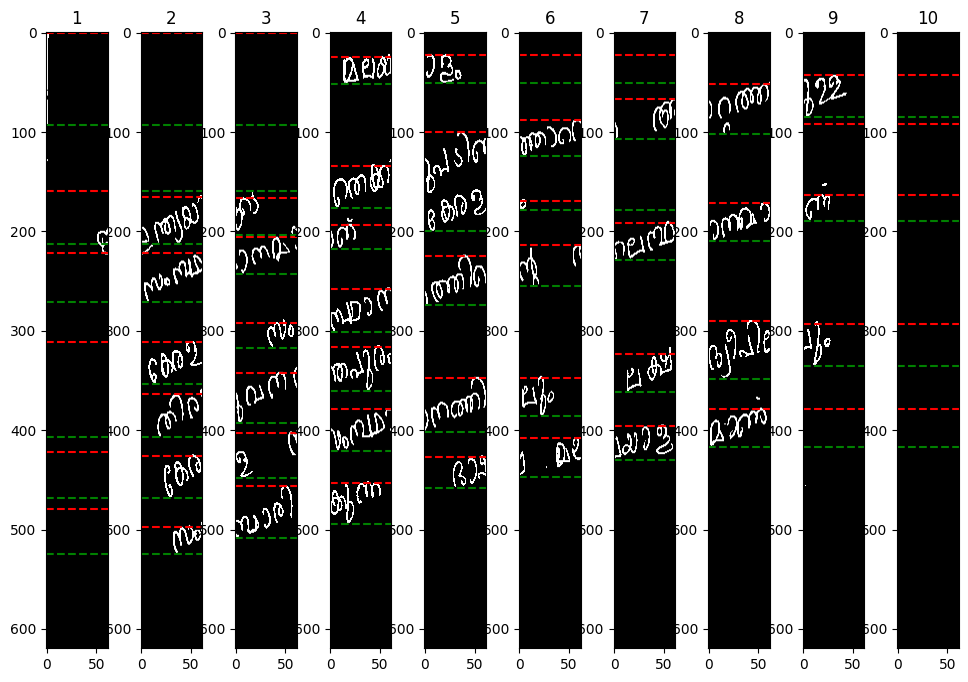

In [42]:
# Plot each chunk with its corresponding horizontal projection profile and detected start/end points
plt.figure(figsize=(12, 8))
for i, chunk in enumerate(chunked_images):
    plt.subplot(1, num_chunks, i + 1)
    
    # Plot the horizontal projection profile
    plt.imshow(chunk, cmap='gray')

    # Draw detected start and end points
    for start_point in start_points[i]:
        plt.axhline(y=start_point, color='red', linestyle='--', label='Start Point')
    for end_point in end_points[i]:
        plt.axhline(y=end_point, color='green', linestyle='--', label='End Point')

    # Hide x and y axis ticks and labels
    # plt.xticks([])
    # plt.yticks([])
    
    # Set plot properties
    plt.title(f'{i+1}')
    # plt.tight_layout()


plt.show()

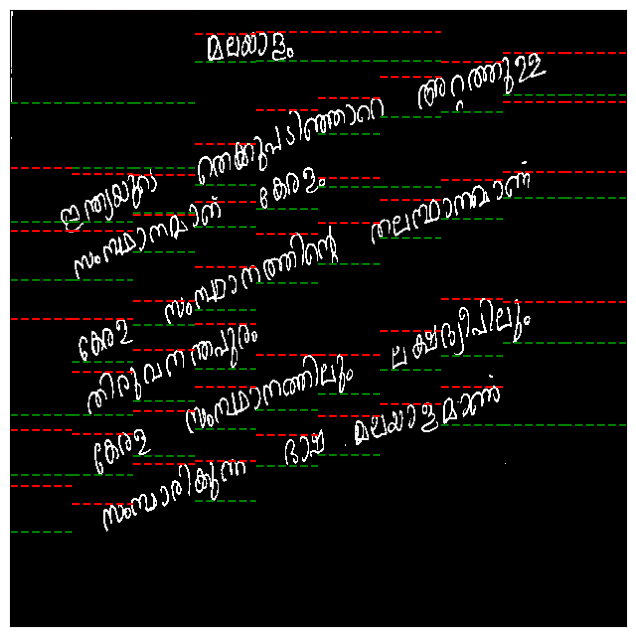

In [43]:


num_strips = 10
strip_width = width // num_strips



plt.figure(figsize=(12, 8))
plt.imshow(thresh_img, cmap='gray')

# Iterate over each strip
for i in range(len(start_points)):
    # Calculate the x-coordinate range for the current strip
    start_x = i * strip_width
    end_x = (i + 1) * strip_width

    # Draw horizontal lines for start and end points in the current strip
    for start_point, end_point in zip(start_points[i], end_points[i]):
        # Ensure start_point and end_point stay within the strip boundaries
        start_y = max(0, min(start_point, height))
        end_y = max(0, min(end_point, height))

        # Draw horizontal lines within the strip boundaries
        plt.axhline(y=start_y, xmin=start_x / width, xmax=end_x / width, color='red', linestyle='--', label='Start Point')
        plt.axhline(y=end_y, xmin=start_x / width, xmax=end_x / width, color='green', linestyle='--', label='End Point')

# Hide x and y axis ticks and labels
plt.xticks([])
plt.yticks([])

plt.show()
